In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import groupby
from scipy import spatial
from itertools import combinations


### Read file with counted codons

In [4]:
counted_codons = pd.read_csv("../data/counted_codons_cytb.csv")
counted_codons = counted_codons.drop("Gene", axis=1)
counted_codons.head()


,Species,ExpectedObserved,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,A[A>G]A,A[A>G]C,A[A>G]G,A[A>G]T,...,T[T>A]G,T[T>A]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
0,Abbottina_obtusirostris,Expected,8.0,4.0,4.0,4.0,8.0,4.0,4.0,4.0,...,12.0,9.0,10.0,14.0,12.0,9.0,10.0,14.0,12.0,9.0
1,Abbottina_obtusirostris,Observed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Abbottina_rivularis,Expected,6.0,3.0,3.0,3.0,6.0,3.0,3.0,3.0,...,8.0,10.0,5.0,9.0,8.0,10.0,5.0,9.0,8.0,10.0
3,Abbottina_rivularis,Observed,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0
4,Abramis_brama,Expected,9.0,3.0,4.0,5.0,9.0,3.0,4.0,5.0,...,13.0,9.0,10.0,15.0,13.0,9.0,10.0,15.0,13.0,9.0


###  Change format of table for better counting

In [5]:
_counted_codons = counted_codons.melt(["Species", "ExpectedObserved"], counted_codons.columns[2:], var_name="Mut")
_counted_codons.head()

,Species,ExpectedObserved,Mut,value
0,Abbottina_obtusirostris,Expected,A[A>C]A,8.0
1,Abbottina_obtusirostris,Observed,A[A>C]A,0.0
2,Abbottina_rivularis,Expected,A[A>C]A,6.0
3,Abbottina_rivularis,Observed,A[A>C]A,0.0
4,Abramis_brama,Expected,A[A>C]A,9.0


In [6]:
mutations = _counted_codons.pivot(index=["Species", "Mut"], columns="ExpectedObserved", values="value").reset_index()
mutations.head()

ExpectedObserved,Species,Mut,Expected,Observed
0,Abbottina_obtusirostris,A[A>C]A,8.0,0.0
1,Abbottina_obtusirostris,A[A>C]C,4.0,0.0
2,Abbottina_obtusirostris,A[A>C]G,4.0,0.0
3,Abbottina_obtusirostris,A[A>C]T,4.0,0.0
4,Abbottina_obtusirostris,A[A>G]A,8.0,0.0


### Calculate RawMuspec for each species

In [7]:
mutations["RawMutSpec"] = (mutations["Observed"] / mutations["Expected"]).fillna(0)
mutations["RawMutSpec"] = mutations["RawMutSpec"].replace(np.inf, 0)
mutations.head()

ExpectedObserved,Species,Mut,Expected,Observed,RawMutSpec
0,Abbottina_obtusirostris,A[A>C]A,8.0,0.0,0.0
1,Abbottina_obtusirostris,A[A>C]C,4.0,0.0,0.0
2,Abbottina_obtusirostris,A[A>C]G,4.0,0.0,0.0
3,Abbottina_obtusirostris,A[A>C]T,4.0,0.0,0.0
4,Abbottina_obtusirostris,A[A>G]A,8.0,0.0,0.0


In [8]:
rawsum_df = mutations.groupby("Species").RawMutSpec.sum().reset_index().rename(columns={"RawMutSpec": "RawMutSpecSum"})
rawsum_df.head()

,Species,RawMutSpecSum
0,Abbottina_obtusirostris,0.922222
1,Abbottina_rivularis,58.567787
2,Abramis_brama,6.833472
3,Acanthogobius_hasta,2.845833
4,Acanthopagrus_latus,0.166667


### Final Mutational spectrum

In [9]:
mutspecs = pd.merge(mutations, rawsum_df, on="Species")
mutspecs["MutSpec"] = mutspecs["RawMutSpec"] / mutspecs["RawMutSpecSum"]
mutspecs.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec
0,Abbottina_obtusirostris,A[A>C]A,8.0,0.0,0.0,0.922222,0.0
1,Abbottina_obtusirostris,A[A>C]C,4.0,0.0,0.0,0.922222,0.0
2,Abbottina_obtusirostris,A[A>C]G,4.0,0.0,0.0,0.922222,0.0
3,Abbottina_obtusirostris,A[A>C]T,4.0,0.0,0.0,0.922222,0.0
4,Abbottina_obtusirostris,A[A>G]A,8.0,0.0,0.0,0.922222,0.0


In [10]:
def getrevers(mut):
    # Stolen from https://github.com/kpotoh/mutspec/blob/master/mutspec/utils/annot.py
    translator = str.maketrans("ACGT", "TGCA")
    new_mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = new_mut.translate(translator)
    return new_mut

### Here we translate our mutspec with reverse on HEAVY CHAIN

In [11]:
mutspecs['Mut'] = mutspecs.Mut.apply(getrevers)
mutspecs["MutBase"] = mutspecs.Mut.str.slice(2, 5)
mutspecs["Context"] = mutspecs.Mut.str.get(0) + mutspecs.Mut.str.get(2) + mutspecs.Mut.str.get(-1)
mutspecs.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context
0,Abbottina_obtusirostris,T[T>G]T,8.0,0.0,0.0,0.922222,0.0,T>G,TTT
1,Abbottina_obtusirostris,G[T>G]T,4.0,0.0,0.0,0.922222,0.0,T>G,GTT
2,Abbottina_obtusirostris,C[T>G]T,4.0,0.0,0.0,0.922222,0.0,T>G,CTT
3,Abbottina_obtusirostris,A[T>G]T,4.0,0.0,0.0,0.922222,0.0,T>G,ATT
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,0.922222,0.0,T>C,TTT


In [12]:
possible_sbs192 = [
    "A[A>C]A", "A[A>C]C", "A[A>C]G", "A[A>C]T", "C[A>C]A", "C[A>C]C", "C[A>C]G", "C[A>C]T", 
    "G[A>C]A", "G[A>C]C", "G[A>C]G", "G[A>C]T", "T[A>C]A", "T[A>C]C", "T[A>C]G", "T[A>C]T", 
    "A[A>G]A", "A[A>G]C", "A[A>G]G", "A[A>G]T", "C[A>G]A", "C[A>G]C", "C[A>G]G", "C[A>G]T", 
    "G[A>G]A", "G[A>G]C", "G[A>G]G", "G[A>G]T", "T[A>G]A", "T[A>G]C", "T[A>G]G", "T[A>G]T", 
    "A[A>T]A", "A[A>T]C", "A[A>T]G", "A[A>T]T", "C[A>T]A", "C[A>T]C", "C[A>T]G", "C[A>T]T", 
    "G[A>T]A", "G[A>T]C", "G[A>T]G", "G[A>T]T", "T[A>T]A", "T[A>T]C", "T[A>T]G", "T[A>T]T", 
    "A[C>A]A", "A[C>A]C", "A[C>A]G", "A[C>A]T", "C[C>A]A", "C[C>A]C", "C[C>A]G", "C[C>A]T", 
    "G[C>A]A", "G[C>A]C", "G[C>A]G", "G[C>A]T", "T[C>A]A", "T[C>A]C", "T[C>A]G", "T[C>A]T", 
    "A[C>G]A", "A[C>G]C", "A[C>G]G", "A[C>G]T", "C[C>G]A", "C[C>G]C", "C[C>G]G", "C[C>G]T", 
    "G[C>G]A", "G[C>G]C", "G[C>G]G", "G[C>G]T", "T[C>G]A", "T[C>G]C", "T[C>G]G", "T[C>G]T", 
    "A[C>T]A", "A[C>T]C", "A[C>T]G", "A[C>T]T", "C[C>T]A", "C[C>T]C", "C[C>T]G", "C[C>T]T", 
    "G[C>T]A", "G[C>T]C", "G[C>T]G", "G[C>T]T", "T[C>T]A", "T[C>T]C", "T[C>T]G", "T[C>T]T", 
    "A[G>A]A", "A[G>A]C", "A[G>A]G", "A[G>A]T", "C[G>A]A", "C[G>A]C", "C[G>A]G", "C[G>A]T", 
    "G[G>A]A", "G[G>A]C", "G[G>A]G", "G[G>A]T", "T[G>A]A", "T[G>A]C", "T[G>A]G", "T[G>A]T", 
    "A[G>C]A", "A[G>C]C", "A[G>C]G", "A[G>C]T", "C[G>C]A", "C[G>C]C", "C[G>C]G", "C[G>C]T", 
    "G[G>C]A", "G[G>C]C", "G[G>C]G", "G[G>C]T", "T[G>C]A", "T[G>C]C", "T[G>C]G", "T[G>C]T", 
    "A[G>T]A", "A[G>T]C", "A[G>T]G", "A[G>T]T", "C[G>T]A", "C[G>T]C", "C[G>T]G", "C[G>T]T", 
    "G[G>T]A", "G[G>T]C", "G[G>T]G", "G[G>T]T", "T[G>T]A", "T[G>T]C", "T[G>T]G", "T[G>T]T", 
    "A[T>A]A", "A[T>A]C", "A[T>A]G", "A[T>A]T", "C[T>A]A", "C[T>A]C", "C[T>A]G", "C[T>A]T", 
    "G[T>A]A", "G[T>A]C", "G[T>A]G", "G[T>A]T", "T[T>A]A", "T[T>A]C", "T[T>A]G", "T[T>A]T", 
    "A[T>C]A", "A[T>C]C", "A[T>C]G", "A[T>C]T", "C[T>C]A", "C[T>C]C", "C[T>C]G", "C[T>C]T", 
    "G[T>C]A", "G[T>C]C", "G[T>C]G", "G[T>C]T", "T[T>C]A", "T[T>C]C", "T[T>C]G", "T[T>C]T", 
    "A[T>G]A", "A[T>G]C", "A[T>G]G", "A[T>G]T", "C[T>G]A", "C[T>G]C", "C[T>G]G", "C[T>G]T", 
    "G[T>G]A", "G[T>G]C", "G[T>G]G", "G[T>G]T", "T[T>G]A", "T[T>G]C", "T[T>G]G", "T[T>G]T", 
]

### Function to draw MutSpec

In [13]:
def _add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black', linewidth=1)
    line.set_clip_on(False)
    ax.add_line(line)


def _label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]


def _label_group_bar_table(ax, df):
    font = {
        'family': 'cursive',
        'color':  'black',
        'weight': 'normal',
        'size': 7,
    }
    rotation = 90
    ypos = -.05
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        if level == 0:
            rotation = 0
            font['size'] = 12

        pos = 0
        for label, rpos in _label_len(df.index, level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', rotation=rotation,
                    fontdict=font, transform=ax.transAxes)
            if level == 0:
                _add_line(ax, pos*scale, ypos)
            pos += rpos
        if level == 0:
            _add_line(ax, pos*scale, ypos)
        ypos -= .05


def plot_mutspec192(edge_mutspec192, label="Mutational spectra", filepath=None):
    df = edge_mutspec192.groupby(["MutBase", "Context"]).mean()
    fig = plt.figure(figsize=(24, 12))
    ax = fig.add_subplot(111)
    sns.barplot(x="Mut", y="MutSpec", data=edge_mutspec192,
                order=possible_sbs192, errwidth=1, ax=fig.gca())

    labels = ['' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    ax.set_xlabel('')
    ax.set_title(label)
    _label_group_bar_table(ax, df)
    fig.subplots_adjust(bottom=.1*df.index.nlevels)
    if filepath is not None:
        plt.savefig(filepath, dpi=300)
    plt.show()

### Plot Mutational Spectrum for all Vertebrates

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


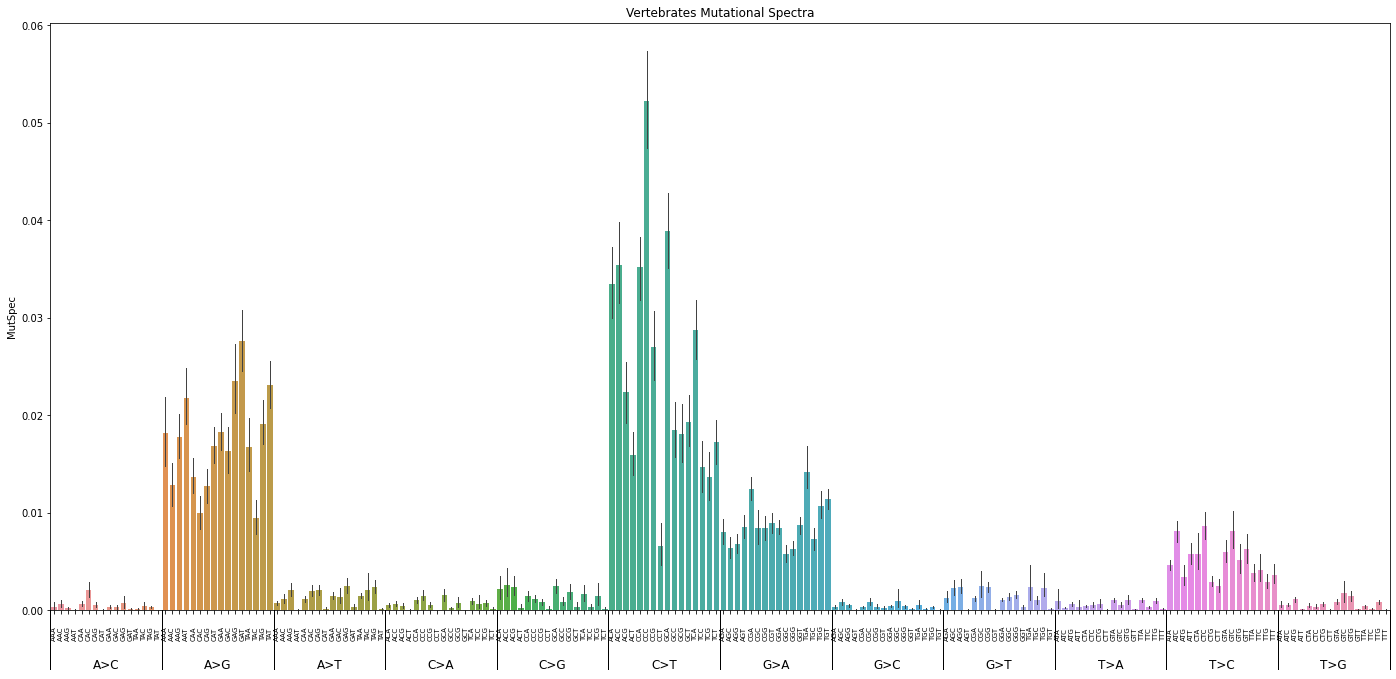

In [14]:
plot_mutspec192(mutspecs, label='Vertebrates Mutational Spectra',
                filepath='../pictures/VerMutSpec.png')

### Add taxonomy and get mutspec for 5 orders

In [15]:
taxa = pd.read_csv('../data/taxa_gb.csv', sep='\t')
taxa.head()

,Class,Species
0,Aves,Corvus_frugilegus
1,Mammalia,Rhinopithecus_bieti
2,Mammalia,Cheracebus_lugens
3,Mammalia,Chiropotes_israelita
4,Mammalia,Callimico_goeldii


### How many classes we have

In [16]:
taxa['Class'].value_counts()

Actinopterygii    2855
Mammalia          1464
Aves              1007
Amphibia           325
Lepidosauria       294
Name: Class, dtype: int64

In [17]:
final_mutspec = pd.merge(mutspecs, taxa, on='Species')
final_mutspec = final_mutspec.drop_duplicates()

In [18]:
final_mutspec['Class'].value_counts()//192

Actinopterygii    456
Mammalia          385
Aves               72
Lepidosauria       36
Amphibia           25
Name: Class, dtype: int64

How many species we have

In [19]:
len(final_mutspec.Species.unique())

974

### Draw Mutational Spectra for different classes

In [20]:
taxes_to_draw = ['Mammalia', 'Aves', 'Actinopterygii', 'Lepidosauria', 'Amphibia']

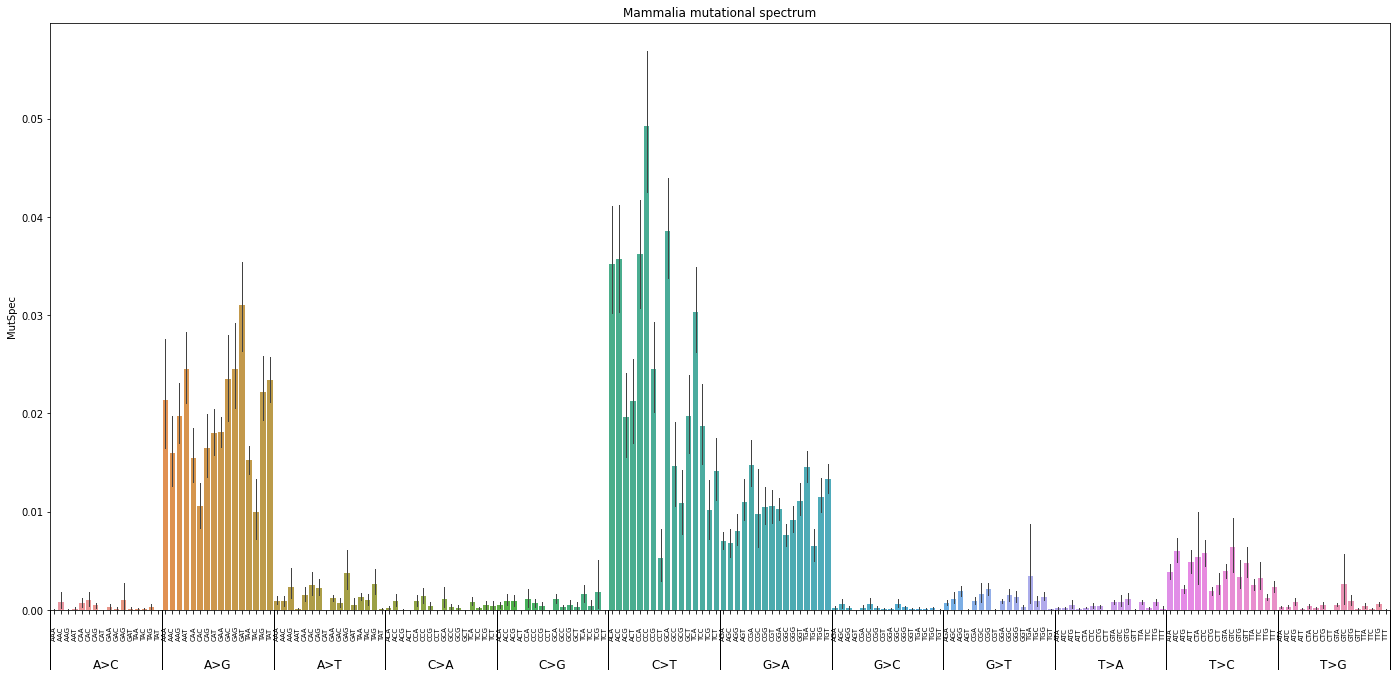

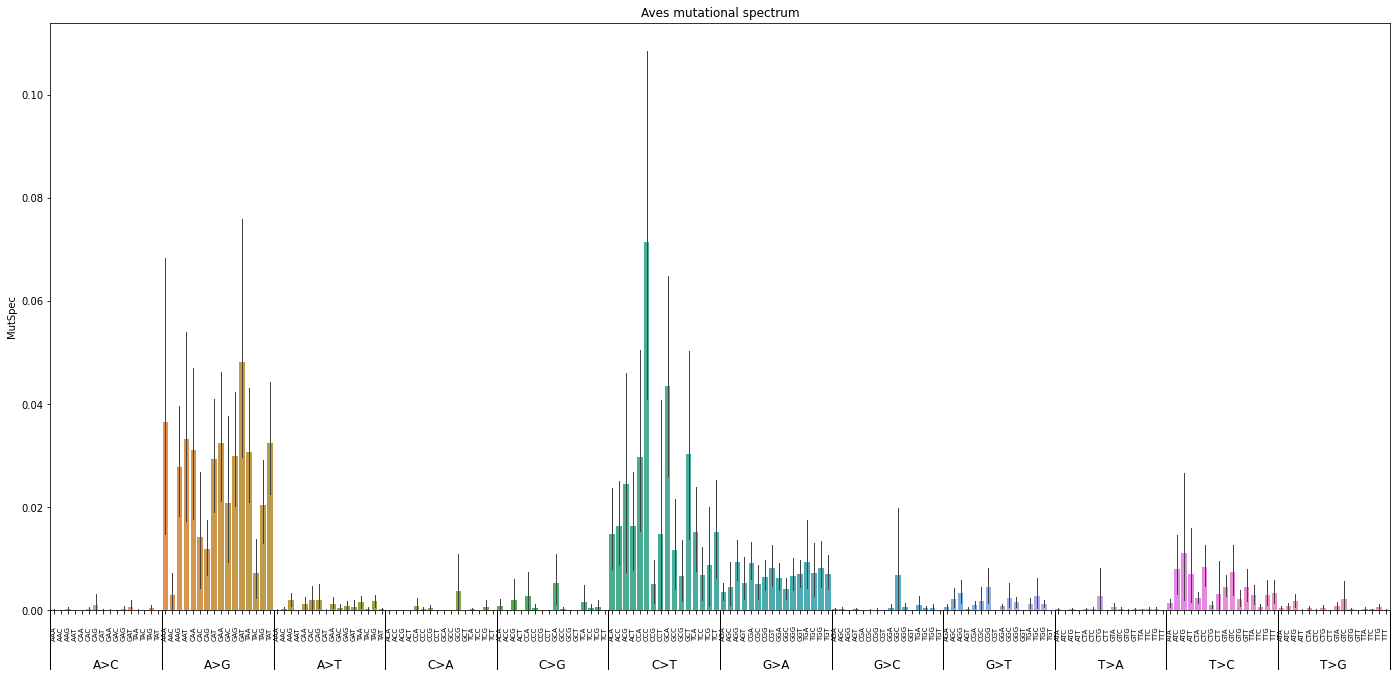

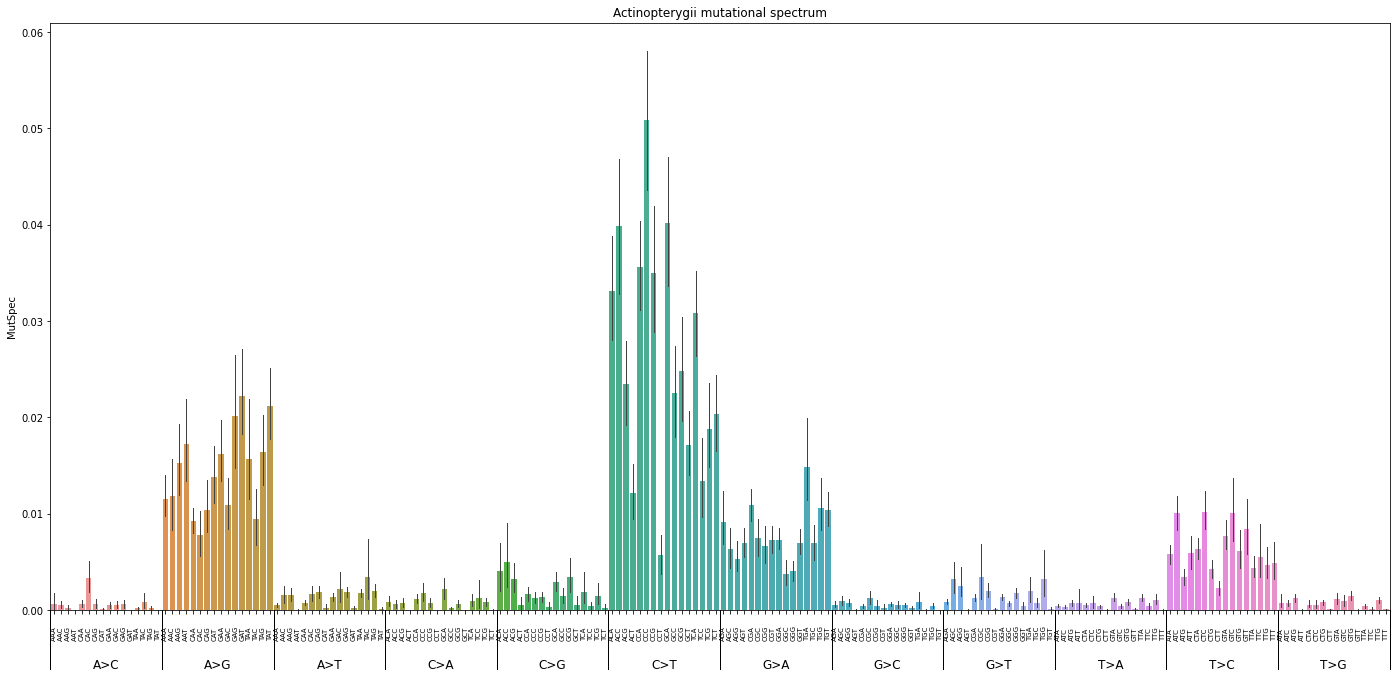

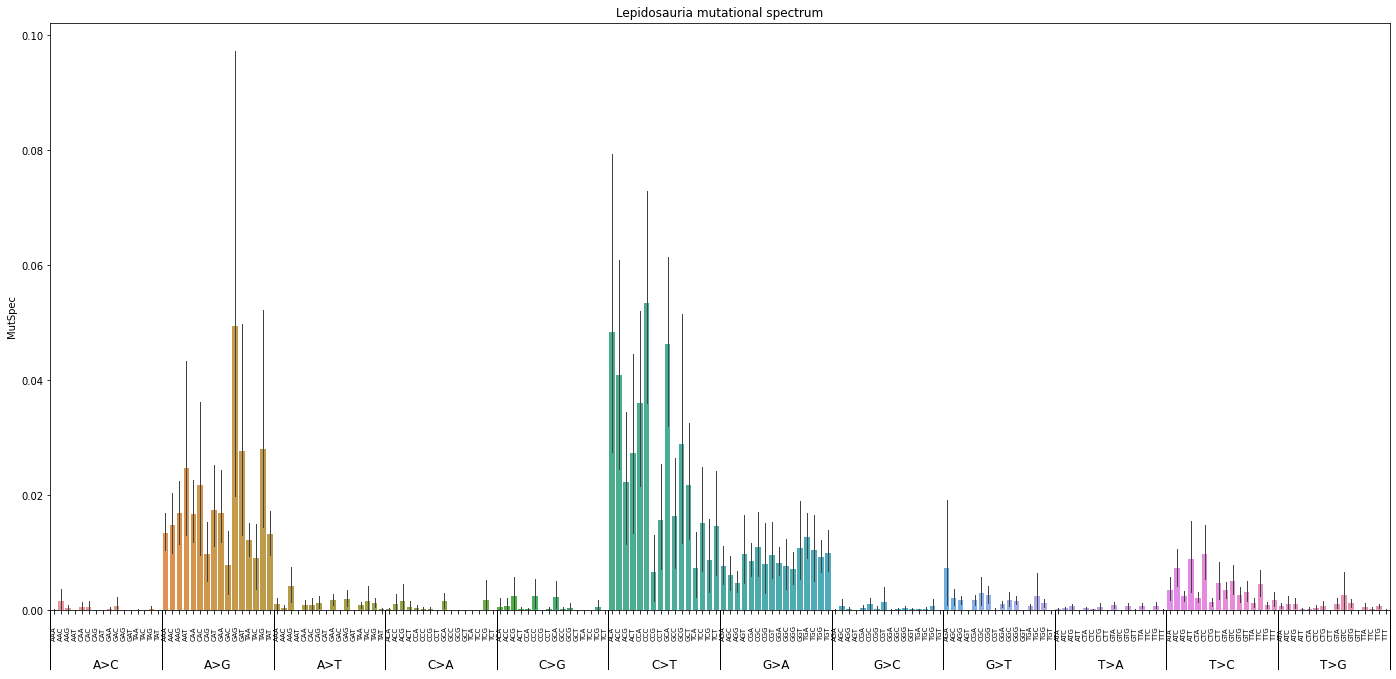

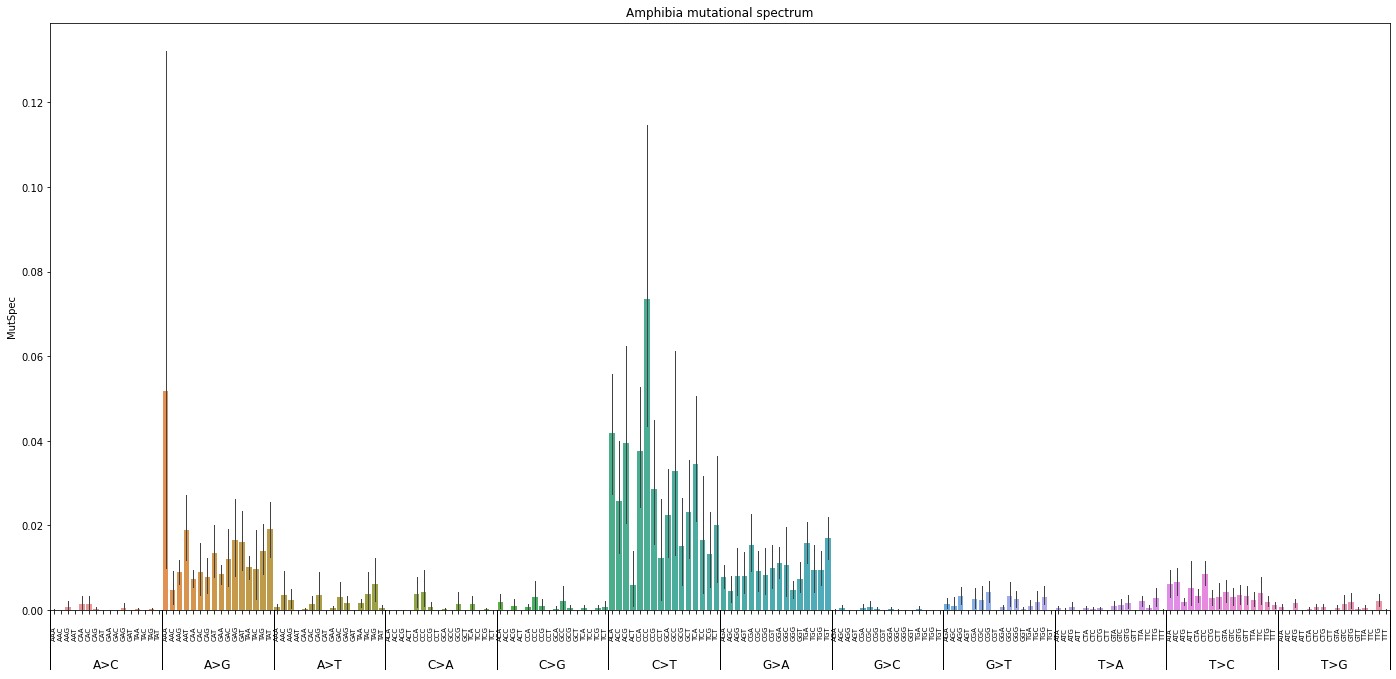

In [21]:
for tax in taxes_to_draw:
    plot_mutspec192(final_mutspec[final_mutspec['Class'] == tax], label=f'{tax} mutational spectrum',
                    filepath=f'../pictures/{tax[:3]}Mutspec.png')

## Analys of similarity

In [22]:
needed_classes = ['Mammalia', 'Aves', 'Amphibia', 'Lepidosauria', 'Actinopterygii', 'exdloop', 'allcytb']

### Calculate mean mutspec for each class 

In [23]:
_met = pd.DataFrame(final_mutspec.groupby(['Class','Mut']).MutSpec.mean().reset_index())
_met.head()

,Class,Mut,MutSpec
0,Actinopterygii,A[A>C]A,0.000663
1,Actinopterygii,A[A>C]C,0.000515
2,Actinopterygii,A[A>C]G,0.000261
3,Actinopterygii,A[A>C]T,0.000013
4,Actinopterygii,A[A>G]A,0.011530


### Download cancer mutspec 

In [25]:
cancer = pd.read_csv('../data/external/cancer_mutspec.csv')
cancer = cancer.loc[:,['Mut','MutSpec_ExDloop','MutSpec_allCYTB']]

In [26]:
exdloop = cancer.iloc[:,[0,1]]
exdloop['Class'] = 'exdloop'
exdloop = exdloop.rename(columns={'MutSpec_ExDloop': 'MutSpec'})
allcytb = cancer.iloc[:,[0,2]]
allcytb['Class'] = 'allcytb'
allcytb = allcytb.rename(columns={'MutSpec_allCYTB': 'MutSpec'})


In [27]:
to_cosinus = pd.concat([exdloop, allcytb, _met])

### Calculate similarities for each combination of observed classes

In [28]:
to_heatmap = []
for comb1 in needed_classes:
    for comb2 in needed_classes:
        cos192 = spatial.distance.cosine(
                    to_cosinus[to_cosinus['Class'] == comb1].MutSpec,
                    to_cosinus[to_cosinus['Class'] == comb2].MutSpec 
                )
        # print(f'Similarity btw {comb[0]} and {comb[1]} is {1-cos192}')
        cos_res = {'Class1':comb1, 'Class2':comb2, 'Similarity':1-cos192}
        to_heatmap.append(cos_res)

### Draw heatmap of similarities

In [29]:
to_heatmap = pd.DataFrame(to_heatmap).pivot('Class2', 'Class1', 'Similarity')
matrix = np.triu(to_heatmap)

In [33]:
to_heatmap.iloc[1:, 1:]

Class1,Amphibia,Aves,Lepidosauria,Mammalia,allcytb,exdloop
Class2,,,,,,
Amphibia,1.000000,0.833112,0.836640,0.902971,0.698940,0.759733
Aves,0.833112,1.000000,0.862396,0.901553,0.540137,0.645045
Lepidosauria,0.836640,0.862396,1.000000,0.929004,0.721371,0.764956
Mammalia,0.902971,0.901553,0.929004,1.000000,0.677204,0.753192
allcytb,0.698940,0.540137,0.721371,0.677204,1.000000,0.856016
exdloop,0.759733,0.645045,0.764956,0.753192,0.856016,1.000000


In [35]:
matrix

array([[1.        , 0.90839694, 0.84355603, 0.90841111, 0.95971377,
        0.716868  , 0.81739575],
       [0.        , 1.        , 0.83311183, 0.83664044, 0.90297131,
        0.69893961, 0.7597328 ],
       [0.        , 0.        , 1.        , 0.86239605, 0.90155283,
        0.5401373 , 0.64504486],
       [0.        , 0.        , 0.        , 1.        , 0.92900388,
        0.72137134, 0.76495552],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.67720428, 0.75319161],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.85601602],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        ]])

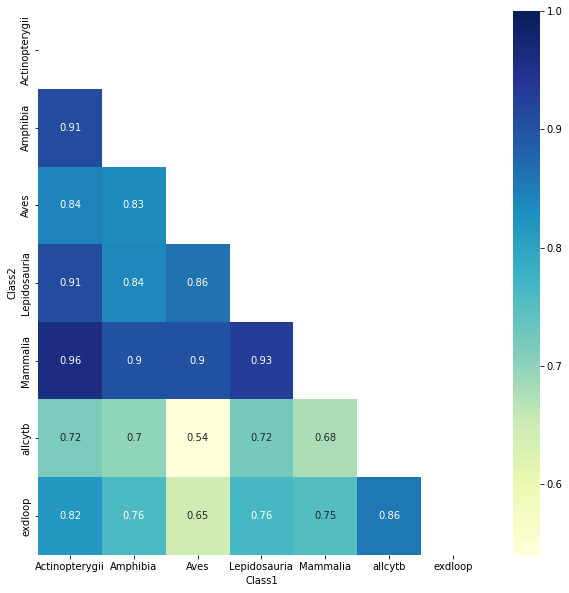

In [53]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(to_heatmap, annot=True, mask=matrix, cmap="YlGnBu", vmax=1)
plt.savefig('../pictures/SimilarityHeatMap.png', dpi=300)